# _Kinetics of Reactions_ ( _Kinexns_ )

## 1. Building and solving the chemical kinetic model from chemkin input files

In [1]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append("/Users/chowdhury/Documents/kinexns")

from kinexns.ode_builder import *
from kinexns.ode_solver import *
from kinexns.parse_chemkin import *

Could not find GLIMDA.


setting up the paths for the input files

In [2]:
cwd = os.getcwd()

file_thermo, file_smiles, file_reaction = set_paths_chemkin_files(cwd)
file_thermo

'/Users/chowdhury/Documents/kinexns/Notebooks/example_chemkin/thermo.dat'

__What are these files? Lets Look at the reaction file first__

<img src = 'images/reaction.png' style = 'height:600px;width:600px'/> 



__Now the thermo and smiles files__

<img src = 'images/thermo.png' style = 'height:600px;width:500px'/> 
<img src = 'images/smiles.png' style = 'height:600px;width:200px'/> 

__Firstly, create a dictionary of all the species with their smiles__

In [3]:
smiles_dict = generate_smile_dict_chemkin(file_smiles)
first5smiles = {k: smiles_dict[k] for k in list(smiles_dict)[:5]}
first5smiles

{'N2': 'N#N', 'AR': '[Ar]', 'HE': '[He]', 'H': '[H]', 'O2': 'O=O'}

__Additionally, we can generate a dictionary of thermodynamic properties for all the 
species at a given temperature__

In [4]:
temp = 950
thermo_dict =  generate_thermo_dict('thermo.dat', smiles_dict, temp)
first5thermo = {k: thermo_dict[k] for k in list(thermo_dict)[:5]}
first5thermo

{'N#N': [32.49308410536418,
  19837.280954717462,
  226.40234513035506,
  -195244.94691911986],
 '[Ar]': [20.785, 13548.702250000002, 178.81048634979848, -156321.25978230857],
 '[He]': [20.785, 13548.702250000002, 150.2329734696345, -129172.62254615276],
 '[H]': [20.784999991659948,
  231533.75843199072,
  138.7978410407275,
  99675.8094432996],
 'O=O': [34.663968430292556,
  20966.875816210275,
  241.7892436524801,
  -208732.9056536458]}

The four values in the values fot each key represents a list of speciefic heat,
enthalpy, entropy and free energy of that epecies at the given temperature

__Finally, we need to parse the chemkin reaction file to get the following things done__

1. Write the reactions in a specific format to a file that can be recognized by *kinexns*
2. Write the Arrhenius rate parameters in a specific format to a file that can be recognized by *kinexns*
3. Get the third body efficiency and pressure dependence reactions and associated parameters

In [5]:
# Supply the names of the files to be written
file_reaction_list = cwd + '/data/complete_reaction_list.dat'
file_rateconstant_list = cwd + '/data/complete_rateconstant_list.dat'

In [6]:
# Get all the informations from the chemkin reaction files using a single function

data_from_chemkin = parse_chemkin_reaction('reaction.dat', smiles_dict, file_reaction_list, file_rateconstant_list)

# data_from_chemkin contains information related to three body efficiency and pressure dependence
# first entry lists all the reactions those have third body efficiency
# second entry lists all the related three body efficiency paremeters
# third entry is a list of lists which contains a. a list of pressure dependent reactions
# b. fall off reaction parameters and c. troe parameters

__Now, we have all the files in the required format__

Its time to create some additional variables required to build the model

In [7]:
# reac_prod_list = A list of reactants and products with their stoichiometric ratios
# speciesindices = a dictionary where the key is the species smiles and 
# value is the number to represent the species
# unique_species = a list of unique species present in the mechanism

reac_prod_list, speciesindices, unique_species = build_species_list(file_reaction_list)
first5species = {k: speciesindices[k] for k in list(speciesindices)[:5]}
first5species

# indices_to_species = dict(zip(speciesindices.values(), speciesindices.keys()))


{'C': 0, 'C#C': 1, 'C#C[O]': 2, 'C#[C]': 3, 'C(OO)C=O': 4}

__Create the stoichiometric matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species__

In [8]:
stoic_matrix = build_stoic_matrix(reac_prod_list, unique_species, speciesindices)
stoic_matrix.shape

(244, 46)

__Create the third body matrix, where the number of rows is equal to number of reactions and
number of columns is equal to number of unique species. The entries represent third body efficiency values__

In [9]:
third_body_matrix = build_third_body_mat(data_from_chemkin, reac_prod_list, unique_species)
third_body_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Now build the rate constant values, both forward and reverse



In [10]:
# be sure to use the correct value of the variable convert. This varialble mentions the unit of the activation energy 
# listed in the rate constant file. The values of convert can be 'cal', 'kcal', 'KJ' and 'J' (the unit in the
# rate constant file)

forward_rate_constants_all = build_forward_rates(file_rateconstant_list, temp, convert='cal')

__Since build_forward_rates fucntion returns both the forward rate constants and parameters, we need to collect the rate parameters in a seperate variable__

In [11]:
forward_rate_constants = forward_rate_constants_all[0]


__Now, the forward rate constants has be updated if there is any pressure dependent reaction__


In [12]:
forward_rate_constants = update_rate_constants_for_pressure(data_from_chemkin, forward_rate_constants, temp)

__Next, if you want to include the reverse rate constants, calculate them using the function build_reverse_rates__

In [13]:
# The value 1 correspondce the converstion factor of the unit of energy in thermo_dict to Joule.
# Here 1 indicates the unit of energy in thermo_dict is Joule.

reverse_rate_constants = build_reverse_rates( thermo_dict, unique_species,stoic_matrix, 1,
                                             forward_rate_constants,temp, chemkin=True)

# If you do not want to include reverse rates in your calcualation just initiate them with zero
# reverse_rate_constants = np.zeros (len(forward_rate_constants))
reverse_rate_constants

[10723083042174.482,
 163637340653.0871,
 2347317407.878262,
 1306660503595.5535,
 5.433710725539609e-06,
 3.2536451061084427e-07,
 2.5932035469690808e-09,
 1.9917134125294715e-05,
 191484.24317811755,
 237.44100474092838,
 10165.595521066589,
 5.7449939149804585,
 3.824343895730642,
 10.824309101897008,
 0.03718404239761744,
 74907.63372899275,
 16893.909101754234,
 15720441.845126461,
 2.1367296219966437e-05,
 281382.776381422,
 48833982.4748832,
 5.2553920253216e-12,
 196779416.27621877,
 1.84489929372728e-05,
 3.4813734391798175,
 93035297721.4492,
 7.622680119475085e-07,
 4.6271302495540023e-07,
 4.774849904173248e-10,
 8.455505530706886e-10,
 173892.1888685137,
 1.2704946509223023e-05,
 7.764627773419946e-07,
 71196683.0722342,
 64447987.945174284,
 303626.01822650013,
 587352521956.2709,
 1309258741.3548062,
 9502644926.168455,
 114537024.69049695,
 22687458695.81879,
 374919489170.7252,
 25598986636.251747,
 244193703377.64783,
 117611783038761.92,
 18712987375845.22,
 0.221270

__Setting up the initial Condition__

In [14]:
y0 = np.zeros((len(unique_species)), dtype = float)
y0[speciesindices['CCC']] = 1
y0[speciesindices['O=O']] = 5
forward_rate_constants[0]


34578278566.516136

__Now it is all set to solve the model__

In [15]:
mod, sim = stiff_ode_solver(stoic_matrix, y0, forward_rate_constants, reverse_rate_constants, third_body = third_body_matrix, sim_time = 2.5e-5, num_data_points=100)

Final Run Statistics: --- 

 Number of steps                                 : 890
 Number of function evaluations                  : 1556
 Number of Jacobian evaluations                  : 27
 Number of function eval. due to Jacobian eval.  : 1242
 Number of error test failures                   : 43
 Number of nonlinear iterations                  : 1552
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 0.7354963720000001 seconds.


__You can now calculate the mol/mass fraction of each species with time using the following function__

In [16]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def generate_mol_mass_fraction(array, species_dict, fraction):
    
    mol_wt = np.zeros((len(species_dict)), dtype = float)

    for i, mol in enumerate(species_dict):
        mol_wt[i] = Descriptors.MolWt(Chem.MolFromSmiles(mol))
    
    if fraction == 'mass':
        mass = array * mol_wt
        frac = mass / mass[1].sum()
    if fraction == 'mol':
        frac = array / array.sum(axis = 1, dtype = float)[:,None]
    
    return frac

mole_frac = generate_mol_mass_fraction(sim, speciesindices, 'mass')


RDKit WARNING: [16:38:31] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [16:38:31] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:38:31] WARNING: not removing hydrogen atom without neighbors


Text(0, 0.5, 'Mass Fraction (%)')

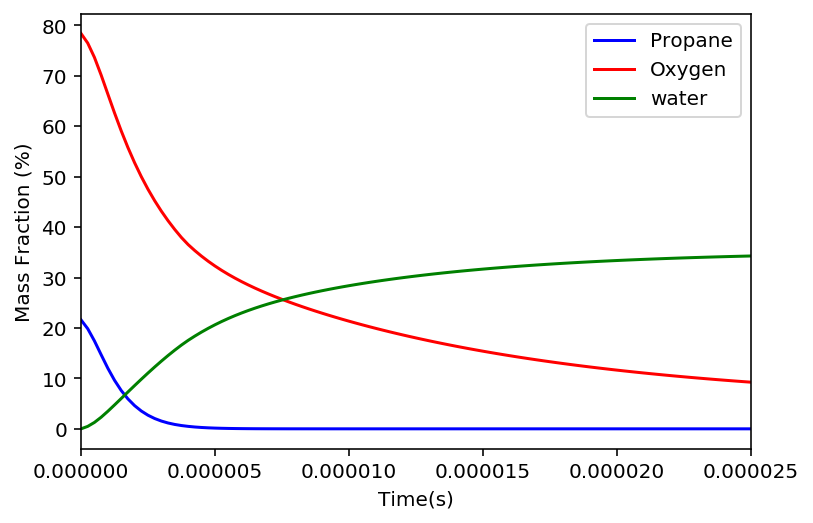

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(mod, mole_frac[:,speciesindices['CCC']] * 100, color="b" , label = 'Propane')
plt.plot(mod, mole_frac[:,speciesindices['O=O']] * 100, color="r" , label = 'Oxygen')
plt.plot(mod, mole_frac[:,speciesindices['O']] *100, color="g" , label = 'water')

#plt.ylim(0,100)
plt.xlim(0,0.000025)
plt.legend()
# plt.xlabel('Time(s)')

plt.xlabel('Time(s)')
plt.ylabel('Mass Fraction (%)')
#plt.yscale('log')

## Optimization of rate parameters

To optimize rate parameters, one needs to get define the output measures to optimize and the associated rate constants. Here, we will optimize against the concentrations of three major species namely propane, oxygne and water.

In [18]:
# optimized species
opt_species = ['CCC', 'O=O', 'O']

# rate parameters to optimize
sensitive_reac = [  1,  19,  22,  23,  89,  90, 219, 230, 236, 239, 242, 243]

Here, we will optimize all the three Arrhenius rate parameters(**A**, **Ea** and **n**) for the above reactions. You can read the initial estimations of these rate parameters from a file, but here we are randomizining them and varying $\pm$20% from their base value.

In [19]:
forward_rate_val = forward_rate_constants_all[0].copy()
forward_rate_params = forward_rate_constants_all[1].copy()
import random
initial_guess = np.array([random.uniform(0.8, 1.2) for i in range (len(sensitive_reac)*3)])
initial_guess = initial_guess.reshape(len(sensitive_reac), 3)

To be more reasonable, we will vary the value of _lnA_ instead of _A_ by $\pm$20% and store the new forward rate parameter values in a variable 

In [20]:
forward_rate_params[:,0] = np.log(forward_rate_params[:,0])

for i,number in enumerate(sensitive_reac):
    forward_rate_params[number] = np.multiply(forward_rate_params[number], initial_guess[i])
 

In [21]:
forward_rate_val= [np.exp(a[0]) * temp ** a[1] * np.exp((- a[2]) * 4.184 / (GAS_CONST * temp))
                   for a in forward_rate_params]

forward_rate_constants_new = forward_rate_val, forward_rate_params


### Here comes the optimization part, we need to define some variables to do so

In [26]:
# define the cost function, usually RMSE
cost_func = 'rmse'

# list the algorithms to perform optimization, there are 10 of them
algorithms = ['mle', 'mcmc', 'sa', 'dds']
#algorithms = ['mc', 'lhs', 'mle', 'mcmc', 'sceua', 'sa', 'rope', 'abc', 'fscabc', 'dds']

# time
t_final = 2.5e-5

# define range of parameters [low, high, max_step, initial]
ini_value = [0.8, 1.25, 0.02, 0.99]

# declare a list to store results
results = []

# number of iterations
rep = 100

# parallel of sequential solver for optimization
parallel = "seq"

# database format, should be custom
dbformat = "custom"

# number of processes to run
processes = len(algorithms)

In [27]:
from kinexns.optimize import *

multi_optimization(processes, rep, sensitive_reac, 'params',
                       speciesindices, ini_value, sim, cost_func, forward_rate_constants_new,
                       file_rateconstant_list, file_thermo, stoic_matrix, unique_species, y0,
                       t_final, algorithms, temp, opt_species, third_body=third_body_matrix, factor=1,
                       chemkin_data=data_from_chemkin, smiles=smiles_dict, energy_conv='cal')

4
Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  100  repetitions
Initializing the  Simulated Annealing (SA) algorithm  with  100  repetitions
Initializing the  Markov Chain Monte Carlo (MCMC) sampler  with  100  repetitions
Initializing the  Maximum Likelihood Estimation (MLE) algorithm  with  100  repetitions
The objective function will be minimized
The objective function will be minimized
The objective function will be minimized
The objective function will be minimized
Starting the MLE algotrithm with 100 repetitions...
Starting the MCMC algotrithm with 100 repetitions...
Starting the SA algotrithm with 100 repetitions...
burnIn...
Initialize  1  chain(s)...
Starting the DDS algotrithm with 100 repetitions...
Finding best starting point for trial 1 using 5 random samples.
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 931
 Number of Jacobian evaluations                  : 

Acceptance rates [%] =50.
Final Run Statistics: --- 

 Number of steps                                 : 1121
 Number of function evaluations                  : 1917
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 79
 Number of nonlinear iterations                  : 1913
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.352053244999979 seconds.
2 of 100, maximal objective function=-12.3052, time remaining: 00:02:05
Final Run Statistics: --- 

 Number of steps                                 : 610
 Number of function evaluations                  : 112

 Number of function evaluations                  : 1026
 Number of Jacobian evaluations                  : 17
 Number of function eval. due to Jacobian eval.  : 782
 Number of error test failures                   : 21
 Number of nonlinear iterations                  : 1022
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0374524999999721 seconds.
6 of 100, maximal objective function=-155735, time remaining: 00:01:37
Final Run Statistics: --- 

 Number of steps                                 : 563
 Number of function evaluations                  : 988
 Number of Jacobian evaluations                  : 14
 Number of function eval. due to Jacobian eval.  : 644
 

 Number of nonlinear iterations                  : 1019
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.0083339629999273 seconds.
10 of 100, maximal objective function=-237505, time remaining: 00:01:26
Final Run Statistics: --- 

 Number of steps                                 : 810
 Number of function evaluations                  : 1528
 Number of Jacobian evaluations                  : 22
 Number of function eval. due to Jacobian eval.  : 1012
 Number of error test failures                   : 61
 Number of nonlinear iterations                  : 1524
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 L

 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.5505973799999992 seconds.
Acceptance rates [%] =40.
Final Run Statistics: --- 

 Number of steps                                 : 652
 Number of function evaluations                  : 1210
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 13
 Number of nonlinear iterations                  : 1206
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulatio

 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.2779761390000886 seconds.
10 of 100, maximal objective function=-7.00478, time remaining: 00:02:28
Final Run Statistics: --- 

 Number of steps                                 : 820
 Number of function evaluations                  : 1463
 Number of Jacobian evaluations                  : 27
 Number of function eval. due to Jacobian eval.  : 1242
 Number of error test failures                   : 39
 Number of nonlinear iterations                  : 1459
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.509587326999963 se

Elapsed simulation time: 1.4538429299999507 seconds.
16 of 100, maximal objective function=-9.34265, time remaining: 00:01:48
Final Run Statistics: --- 

 Number of steps                                 : 1023
 Number of function evaluations                  : 1843
 Number of Jacobian evaluations                  : 35
 Number of function eval. due to Jacobian eval.  : 1610
 Number of error test failures                   : 69
 Number of nonlinear iterations                  : 1839
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.0593246370000315 seconds.
12 of 100, maximal objective function=-7.00478, time remaining: 00:02:30
Final Run Statistics: --- 

 Number

Final Run Statistics: --- 

 Number of steps                                 : 689
 Number of function evaluations                  : 1266
 Number of Jacobian evaluations                  : 19
 Number of function eval. due to Jacobian eval.  : 874
 Number of error test failures                   : 38
 Number of nonlinear iterations                  : 1262
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.156244241999957 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 910
 Number of function evaluations                  : 1708
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian ev

 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Tolerances (relative)    : 1e-06

 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.4995244850000518 seconds.
Elapsed simulation time: 1.9335242130000552 seconds.
Acceptance rates [%] =60.
17 of 100, maximal objective function=-7.00478, time remaining: 00:02:19
Final Run Statistics: --- 

 Number of steps                                 : 1098
 Number of function evaluations                  : 1965
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 98
 Number of nonlinear iterations                  : 1961
 Nu

 Number of nonlinear iterations                  : 1473
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.5981709369999635 seconds.
24 of 100, maximal objective function=-5.8758, time remaining: 00:01:46
Final Run Statistics: --- 

 Number of steps                                 : 924
 Number of function evaluations                  : 1560
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 53
 Number of nonlinear iterations                  : 1556
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 L

 Number of error test failures                   : 48
 Number of nonlinear iterations                  : 1510
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.583565247000024 seconds.
Acceptance rates [%] =61.54
Final Run Statistics: --- 

 Number of steps                                 : 1067
 Number of function evaluations                  : 1861
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 83
 Number of nonlinear iterations                  : 1857
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   


Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7592727319999995 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 879
 Number of function evaluations                  : 1618
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 41
 Number of nonlinear iterations                  : 1614
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relat

 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.079004527000052 seconds.
26 of 100, maximal objective function=-6.34186, time remaining: 00:02:14
Final Run Statistics: --- 

 Number of steps                                 : 1026
 Number of function evaluations                  : 1822
 Number of Jacobian evaluations                  : 37
 Number of function eval. due to Jacobian eval.  : 1702
 Number of error test failures                   : 67
 Number of nonlinear iterations                  : 1818
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1

 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.9041667810000718 seconds.
31 of 100, maximal objective function=-5.35531, time remaining: 00:01:54
Final Run Statistics: --- 

 Number of steps                                 : 942
 Number of function evaluations                  : 1650
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 59
 Number of nonlinear iterations                  : 1646
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulat

38 of 100, maximal objective function=-5.8758, time remaining: 00:01:31
Acceptance rates [%] =70.27
Final Run Statistics: --- 

 Number of steps                                 : 750
 Number of function evaluations                  : 1318
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 43
 Number of nonlinear iterations                  : 1314
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.3016520979999768 seconds.
41 of 100, maximal objective function=-11.797, time remaining: 00:01:22
Final Run Statistics: --- 

 Number of steps                   

Final Run Statistics: --- 

 Number of steps                                 : 905
 Number of function evaluations                  : 1689
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 47
 Number of nonlinear iterations                  : 1685
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.946864655000013 seconds.
36 of 100, maximal objective function=-4.92235, time remaining: 00:01:48
Final Run Statistics: --- 

 Number of steps                                 : 1060
 Number of function evaluations                  : 1855
 Number of Jacobian eva

 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.9723091939999904 seconds.
46 of 100, maximal objective function=-11.797, time remaining: 00:01:18
Final Run Statistics: --- 

 Number of steps                                 : 1007
 Number of function evaluations                  : 1829
 Number of Jacobian evaluations                  : 41
 Number of function eval. due to Jacobian eval.  : 1886
 Number of error test failures                   : 57
 Number of nonlinear iterations                  : 1825
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.3261444529999835 seconds.
35 of 100, maximal objecti

 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.1262172450000207 seconds.
37 of 100, maximal objective function=-5.62855, time remaining: 00:02:00
Final Run Statistics: --- 

 Number of steps                                 : 1003
 Number of function evaluations                  : 1842
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 67
 Number of nonlinear iterations                  : 1838
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.103999771000076 seconds.
41 of 100, maximal objecti

 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.8560542970000142 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 1097
 Number of function evaluations                  : 1905
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 94
 Number of nonlinear iterations                  : 1901
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.9821423619999905 seconds.
51 of 100, maximal objective function=-11.797, time remaining: 0

Elapsed simulation time: 1.6332687009999063 seconds.
52 of 100, maximal objective function=-5.8758, time remaining: 00:01:14
Acceptance rates [%] =78.43
Final Run Statistics: --- 

 Number of steps                                 : 915
 Number of function evaluations                  : 1712
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 1518
 Number of error test failures                   : 57
 Number of nonlinear iterations                  : 1708
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.8063371160000088 seconds.
46 of 100, maximal objective function=-4.889, time remaining: 00:01:35
Final Run S

Final Run Statistics: --- 

 Number of steps                                 : 849
 Number of function evaluations                  : 1421
 Number of Jacobian evaluations                  : 27
 Number of function eval. due to Jacobian eval.  : 1242
 Number of error test failures                   : 50
 Number of nonlinear iterations                  : 1417
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.5465111920000254 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 847
 Number of function evaluations                  : 1555
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian 

 Number of function evaluations                  : 1856
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 66
 Number of nonlinear iterations                  : 1852
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.035500772999967 seconds.
51 of 100, maximal objective function=-4.35322, time remaining: 00:01:26
Final Run Statistics: --- 

 Number of steps                                 : 892
 Number of function evaluations                  : 1478
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 12

 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 33
 Number of nonlinear iterations                  : 1506
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.8061709180000207 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 861
 Number of function evaluations                  : 1440
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 1150
 Number of error test failures                   : 53
 Number of nonlinear iterations                  : 1436
 Number of nonl

 Number of nonlinear iterations                  : 1760
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.8768185839999205 seconds.
65 of 100, maximal objective function=-11.797, time remaining: 00:00:53
Final Run Statistics: --- 

 Number of steps                                 : 1009
 Number of function evaluations                  : 1864
 Number of Jacobian evaluations                  : 34
 Number of function eval. due to Jacobian eval.  : 1564
 Number of error test failures                   : 53
 Number of nonlinear iterations                  : 1860
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 


Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.5798780680000846 seconds.
52 of 100, maximal objective function=-5.59947, time remaining: 00:01:35
Final Run Statistics: --- 

 Number of steps                                 : 1005
 Number of function evaluations                  : 1697
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 85
 Number of nonlinear iterations                  : 1693
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal


Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.9775447350000377 seconds.
70 of 100, maximal objective function=-11.797, time remaining: 00:00:46
Final Run Statistics: --- 

 Number of steps                                 : 807
 Number of function evaluations                  : 1481
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 1426
 Number of error test failures                   : 40
 Number of nonlinear iterations                  : 1477
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal o

 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7387671889999865 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 738
 Number of function evaluations                  : 1443
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 21
 Number of nonlinear iterations                  : 1439
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.6221634710000217 seconds.
Final Run Statistics: --- 

 Number of steps                     

59 of 100, maximal objective function=-5.59947, time remaining: 00:01:21
Final Run Statistics: --- 

 Number of steps                                 : 921
 Number of function evaluations                  : 1676
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 55
 Number of nonlinear iterations                  : 1672
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7874613989999943 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 834
 Number of function evaluations                  : 1418
 Number of Jacobian eva

Elapsed simulation time: 2.3602926830000115 seconds.
61 of 100, maximal objective function=-5.59931, time remaining: 00:01:17
Final Run Statistics: --- 

 Number of steps                                 : 1117
 Number of function evaluations                  : 1955
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 88
 Number of nonlinear iterations                  : 1951
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.20535716400002 seconds.
78 of 100, maximal objective function=-11.797, time remaining: 00:00:34
Final Run Statistics: --- 

 Number of

Final Run Statistics: --- 

 Number of steps                                 : 877
 Number of function evaluations                  : 1643
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 1518
 Number of error test failures                   : 35
 Number of nonlinear iterations                  : 1639
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7994508510000742 seconds.
71 of 100, maximal objective function=-4.35322, time remaining: 00:00:51
Final Run Statistics: --- 

 Number of steps                                 : 1028
 Number of function evaluations                  : 1870
 Number of Jacobian ev

 Number of function evaluations                  : 1836
 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 1426
 Number of error test failures                   : 82
 Number of nonlinear iterations                  : 1832
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
Final Run Statistics: --- 
 Linear multistep method  : BDF

 Number of steps                                 : 957
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Number of function evaluations                  : 1587
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 52
 Number of nonlinear iterations                  : 1583
 Number of n

 Number of Jacobian evaluations                  : 31
 Number of function eval. due to Jacobian eval.  : 1426
 Number of error test failures                   : 47
 Number of nonlinear iterations                  : 1706
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.9647467629999937 seconds.
76 of 100, maximal objective function=-4.35322, time remaining: 00:00:42
Final Run Statistics: --- 

 Number of steps                                 : 902
 Number of function evaluations                  : 1577
 Number of Jacobian evaluations                  : 26
 Number of function eval. due to Jacobian eval.  : 1196
 Number of error test failures                   : 5

 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 88
 Number of nonlinear iterations                  : 1878
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7697329840000293 seconds.
88 of 100, maximal objective function=-11.797, time remaining: 00:00:18
Final Run Statistics: --- 

 Number of steps                                 : 870
 Number of function evaluations                  : 1620
 Number of Jacobian evaluations                  : 33
 Number of function eval. due to Jacobian eval.  : 1518
 Number of error test failures                   : 53

 Number of nonlinear iterations                  : 1728
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.0164876140000842 seconds.
73 of 100, maximal objective function=-5.44967, time remaining: 00:00:53
Final Run Statistics: --- 

 Number of steps                                 : 801
 Number of function evaluations                  : 1420
 Number of Jacobian evaluations                  : 30
 Number of function eval. due to Jacobian eval.  : 1380
 Number of error test failures                   : 43
 Number of nonlinear iterations                  : 1416
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 


Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.3502455979999013 seconds.
75 of 100, maximal objective function=-5.44967, time remaining: 00:00:49
Final Run Statistics: --- 

 Number of steps                                 : 820
 Number of function evaluations                  : 1464
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 49
 Number of nonlinear iterations                  : 1460
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal 

 Number of nonlinear iterations                  : 2077
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.2182060000000092 seconds.
77 of 100, maximal objective function=-5.42853, time remaining: 00:00:46
Final Run Statistics: --- 

 Number of steps                                 : 867
 Number of function evaluations                  : 1499
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1334
 Number of error test failures                   : 48
 Number of nonlinear iterations                  : 1495
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 

 Number of nonlinear iterations                  : 1873
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 2.0498814019999827 seconds.
79 of 100, maximal objective function=-5.42853, time remaining: 00:00:42
Final Run Statistics: --- 

 Number of steps                                 : 1018
 Number of function evaluations                  : 1689
 Number of Jacobian evaluations                  : 32
 Number of function eval. due to Jacobian eval.  : 1472
 Number of error test failures                   : 63
 Number of nonlinear iterations                  : 1685
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode



Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.7211971530000483 seconds.
Final Run Statistics: --- 

 Number of steps                                 : 1020
 Number of function evaluations                  : 1866
 Number of Jacobian evaluations                  : 40
 Number of function eval. due to Jacobian eval.  : 1840
 Number of error test failures                   : 42
 Number of nonlinear iterations                  : 1862
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (rela

85 of 100, maximal objective function=-5.40453, time remaining: 00:00:29
Final Run Statistics: --- 

 Number of steps                                 : 918
 Number of function evaluations                  : 1640
 Number of Jacobian evaluations                  : 28
 Number of function eval. due to Jacobian eval.  : 1288
 Number of error test failures                   : 52
 Number of nonlinear iterations                  : 1636
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.1735327200000256 seconds.
97 of 100, maximal objective function=-4.35322, time remaining: 00:00:04
Final Run Statistics: --- 

 Number of steps                                 : 980
 Numbe

 Number of nonlinear iterations                  : 2016
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-10
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 2.5e-05 seconds.
Elapsed simulation time: 1.2842122249999193 seconds.
91 of 100, maximal objective function=-5.40443, time remaining: 00:00:16
Final Run Statistics: --- 

 Number of steps                                 : 1050
 Number of function evaluations                  : 1858
 Number of Jacobian evaluations                  : 39
 Number of function eval. due to Jacobian eval.  : 1794
 Number of error test failures                   : 43
 Number of nonlinear iterations                  : 1854
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode


A236: 0.91943
n236: 0.813693
E236: 0.993884
A239: 1.04547
n239: 0.837077
E239: 1.21224
A242: 0.911158
n242: 0.905227
E242: 1.14668
A243: 0.828179
n243: 1.10339
E243: 0.984711
******************************



[None, None, None, None]

In [ ]:
sim.shape

In [ ]:
len(observations)

In [ ]:
sim[:,1]